# 1. Prepare Data

In [1]:
import numpy as np
import pandas as pd
import textwrap
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv("/kaggle/input/sephora-reviews/TRAIN.csv", index_col=[0])
val = pd.read_csv("/kaggle/input/sephora-reviews/VAL.csv", index_col=[0])
test = pd.read_csv("/kaggle/input/sephora-reviews/TEST.csv", index_col=[0])

print(f"Train size: {train.shape}\nValidation size: {val.shape}\nTest size: {test.shape}")
pd.set_option('max_colwidth', 250)
train.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train size: (177616, 2)
Validation size: (59206, 2)
Test size: (59206, 2)


review_text  \
8403    I received this product free from influenster in one of their voxboxes. I started noticing fine lines and wrinkles on my skin in my early 20s. it’s really changing how my skin looks and feels!!! the serum itself is thin and lightweight but packs ...   
417589  This is definably top 3 best lip balms I’ve ever used. If you have chronic dry flaky lips this will make a difference but THE PRICE. I went through this in less than two months and I can’t justify going back to this on a regular basis. Reserving ...   
81170                                                                                                                                                               I am so impressed! I sleep so soundly and wakeup feeling refreshed not groggy.  I love these!   
414449  This is a very light, watery consistency that isn’t really hydrating. It is a bit sticky for 20 minutes until it dries, then the hydration doesn’t last more than 2 hours. It doesn’t make my skin glow either. I don’t recommend this as a daily mois...   
68274                                                                                                      i really liked the texture of this mask, but i was not a fan of the scent it was a clay-ish plastic smell. it made my skin soft and the price is fair.   

        is_recommended  
8403                 1  
417589               1  
81170                1  
414449               0  
68274                0

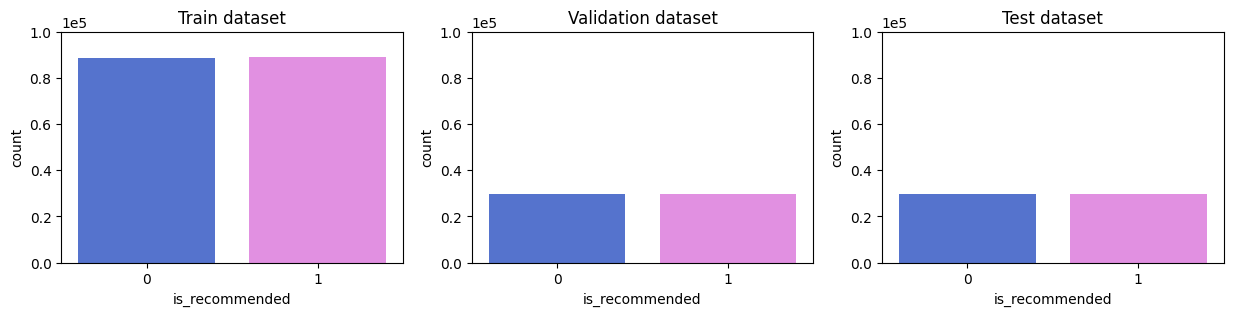

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # plotting target proportion

for d, label in zip(
    enumerate([train, val, test]), 
    ["Train dataset", "Validation dataset", "Test dataset"]):
    
    ind, dataset = d
    g = sns.countplot(
        x="is_recommended", 
        data=dataset, 
        palette=["royalblue","violet"], 
        ax=axes[ind%3])
    g.set_ylim(0, 1e5)
    g.ticklabel_format(style='sci', scilimits=(0, 0), axis='y')
    g.title.set_text(f"{label}")

# 2. General Settings

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # we will train the model on the single node

import time
import torch
import requests
import pandas as pd

import torchtext
import torch.nn.functional as F

import transformers
from transformers import DistilBertForSequenceClassification, AdamW

torch.backends.cudnn.deterministic = True
RANDOM_SEED = 777
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
# pip install wandb --upgrade

# 3. Tokenization

Tokenization is a fundamental step in NLP tasks because it structures and prepares text for analysis, particularly in our downstream task.

In [5]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
texts_lengths = train.review_text.str.len()
texts_lengths.describe()

count    177616.000000
mean        315.149378
std         225.834303
min          20.000000
25%         168.000000
50%         259.000000
75%         396.000000
max        2000.000000
Name: review_text, dtype: float64

So, the longest review has the lenght of 2000 characters, and the shortest one - only 20. The distribution of reviews' lenghts is on the histogram below. As we can see, there is an asymmetry normal distribution with "heavy" right tail. In this situation, we can leave num_tokens=512 by default, it will be enough for us.

In [6]:
sns.histplot(texts_lengths.values, color="royalblue")

<Axes: ylabel='Count'>

In [7]:
%%time
train_encodings = tokenizer(train.review_text.to_list(), truncation=True, padding=True)
valid_encodings = tokenizer(val.review_text.to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test.review_text.to_list(), truncation=True, padding=True)

train_encodings[0]

CPU times: user 2min 17s, sys: 21 s, total: 2min 38s
Wall time: 58.9 s


Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

### *No preprocess except tockenization 🤗*

Preprocessing is **not needed when using pre-trained language representation models like BERT**. In particular, it uses all of the information in a sentence, even punctuation and stop-words, from a wide range of perspectives by leveraging a multi-head self attention mechanism. After stemming, BERT's performance of text classification will decrease.

In [8]:
text_example = val.review_text.loc[777]

print("Tokenized text:\n", textwrap.fill(str(tokenizer.tokenize(text_example)), width=80))
print()
print("IDs of tokens:\n", textwrap.fill(str(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_example))), width=80))

Tokenized text:
 ['i', 'liked', 'the', 'subtle', 'banana', 'scent', 'and', 'felt', 'like', 'the',
'product', 'did', 'a', 'nice', 'job', 'hydra', '##ting', 'my', 'under', '-',
'eye', 'without', 'adding', 'any', 'grease', 'to', 'my', 'face', '.', 'i',
'have', 'been', 'using', 'der', '##mal', '##og', '##ica', '’', 's', 'circular',
'hydra', '##tion', 'serum', 'for', '6', 'weeks', 'and', 'my', 'skin', 'has',
'never', 'felt', 'more', 'plump', 'and', 'hydra', '##ted', '.', 'i', 'love',
'how', 'easily', 'i', 'can', 'layer', 'it', 'under', 'my', 'usual', 'moist',
'##uri', '##zer', 'day', 'or', 'night', '.', 'this', 'serum', 'has', 'helped',
'with', 'cell', 'turnover', 'which', 'decreases', 'the', 'likelihood', 'of',
'ac', '##ne', 'scar', '##ring', '.', 'a', 'der', '##mal', '##og', '##ica',
'skin', 'therapist', 'recommended', 'that', 'i', 'include', 'more', 'hydra',
'##tion', 'in', 'my', 'skin', 'to', 'help', 'with', 'my', 'adult', 'ac', '##ne',
'and', 'this', 'serum', 'is', 'definitely', 'makin

Word clouds provide a quick and visually appealing way to summarize the most common or prominent words in a text or corpus. By showing the words in varying font sizes based on their frequency, word clouds give an immediate sense of the most important terms.

In [9]:
%%time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


stopwords = set(STOPWORDS)  # For remove stopwords
stops = []
with open('/kaggle/input/stops1/stop_words_english.txt') as input_file:
    for row in input_file.readlines():
        stops.append(row.strip())
stopwords.update(stops)
print(f'Size of stopwords base is: {len(stopwords)}')


wordcloud = WordCloud(      # Create a word cloud
    width=800, 
    height=400, 
    stopwords=stopwords, 
    max_words=20, 
    background_color='lavenderblush')\
.generate(' '.join(train.review_text))

plt.figure(figsize=(6, 3))  # Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

Size of stopwords base is: 3559
CPU times: user 24.3 s, sys: 612 ms, total: 24.9 s
Wall time: 25 s


# 4. Dataset Class, Loaders

Let's create our own class in order to generate a dataset for later loading.

In [10]:
class SephoraDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
train_dataset = SephoraDataset(train_encodings, train.is_recommended.to_list())
valid_dataset = SephoraDataset(valid_encodings, val.is_recommended.to_list())
test_dataset = SephoraDataset(test_encodings, test.is_recommended.to_list())

In PyTorch, the DataLoaderIn PyTorch, the DataLoader is a utility that helps handle is a utility that large is especially valuable when working datasets efficiently during the training with large datasets for tasks like deep learning. Large datasets becomes are often too big to fit essential to into memory all efficiently at once. load Data andLoader enables batch processing process the data, where in the dataset is divided into smaller batches, allowing you to mini-b train or evaluate your modelatches, on one batch at a time. This significantly reduces especially when the memory requirements entire.

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

#  5. Load Model for fine-tuning

The key idea behind fine-tuning DistilBERT is to take advantage of its understanding capabilities and adapt them to our specific NLP task with relatively little additional training. This approach will to better performance and faster convergence compared to training a model from scratch.

In [13]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)
model.train()

optim = AdamW(model.parameters(), lr=5e-5, no_deprecation_warning=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#  6. Train Model for our down-stream task

In [14]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [15]:
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
    evaluation_strategy = 'steps',   # evaluation per step
    eval_steps = 6000,               # evaluae and save every step
    save_total_limit=1,              # save current checkpoint
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    num_train_epochs=3,              # total number of training epochs
    weight_decay=0.01,               # strength of weight decay
    metric_for_best_model = 'f1',    # check metric
    load_best_model_at_end=True,     # we should save our best model
    output_dir='./results',          # output directory
    warmup_steps=6000,               # number of warmup steps for learning rate scheduler
    logging_dir='./logs',            # directory for storing logs
    logging_steps=6000,              # step for log in the table
    save_steps=6000,                 # how often the model and optimizer states are saved during training
    seed=RANDOM_SEED                 # provides reproducibility
)

trainer = Trainer(
    model=model,                     # the 🤗 Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=valid_dataset,      # evaluation dataset
    compute_metrics=compute_metrics, # metrics for the table
    callbacks = [transformers.EarlyStoppingCallback(early_stopping_patience=3)]
)

In [16]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TrainOutput(global_step=33303, training_loss=0.14445312012495826, metrics={'train_runtime': 17408.3537, 'train_samples_per_second': 30.609, 'train_steps_per_second': 1.913, 'total_flos': 7.058498843905229e+16, 'train_loss': 0.14445312012495826, 'epoch': 3.0})

# 7. Save the fine-tuned model to local in .zip

In [17]:
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/wandb/debug-internal.log
/kaggle/working/wandb/debug.log
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/run-ffsgnhuh.wandb
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/files/config.yaml
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/files/output.log
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/files/conda-environment.yaml
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/files/requirements.txt
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/files/wandb-summary.json
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/files/wandb-metadata.json
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/logs/debug-internal.log
/kaggle/working/wandb/run-20231105_142148-ffsgnhuh/logs/debug.log
/kaggle/working/results/checkpoint-30000/scheduler.pt
/kaggle/working/results/checkpoint-30000/config.json
/kaggle/working/results/checkpoint-30000/optimizer.pt
/kaggle/working/results/checkpoint-30000/rng_state.pth
/kaggle/working/results/checkpoint-30000/pytorch_model.b

In [18]:
%%time
from shutil import make_archive


make_archive(
  'fine-tuned-model', 
  'zip',                                # the archive format - or tar, bztar, gztar 
  root_dir=None,                        # root for archive - current working dir if None
  base_dir="/kaggle/working/results/checkpoint-30000/")   # start archiving from here - cwd if None too

CPU times: user 38.3 s, sys: 881 ms, total: 39.2 s
Wall time: 39.2 s


'fine-tuned-model.zip'

# 8. Evaluate

In [19]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():
        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(tqdm(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']

            _, predicted_labels = torch.max(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
            
    return correct_pred.float()/num_examples * 100

In [20]:
%%time
model.eval()
model.to(DEVICE)

print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

  0%|          | 0/3701 [00:00<?, ?it/s]

Test accuracy: 95.51%
CPU times: user 8min 31s, sys: 2.48 s, total: 8min 33s
Wall time: 8min 31s


# 9. Load the fine-tuned model

In [24]:
model = DistilBertForSequenceClassification.from_pretrained('/kaggle/working/results/checkpoint-30000')
model.to(DEVICE)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [25]:
for dirname, _, filenames in os.walk('/kaggle/working/results/checkpoint-30000'):
    for filename in filenames:
        data_file = os.path.join(dirname, filename)
        size = round(os.path.getsize(data_file)/(pow(1024,2)), 2)
        print(f"{data_file}: {size} MB")

/kaggle/working/results/checkpoint-30000/scheduler.pt: 0.0 MB
/kaggle/working/results/checkpoint-30000/config.json: 0.0 MB
/kaggle/working/results/checkpoint-30000/optimizer.pt: 510.91 MB
/kaggle/working/results/checkpoint-30000/rng_state.pth: 0.01 MB
/kaggle/working/results/checkpoint-30000/pytorch_model.bin: 255.45 MB
/kaggle/working/results/checkpoint-30000/trainer_state.json: 0.0 MB
/kaggle/working/results/checkpoint-30000/training_args.bin: 0.0 MB


# 10. Explore some predictions

In [26]:
case = 1
for text, label in zip(test.review_text[10:20].to_list(), test.is_recommended[:10].to_list()):
    to_predict = tokenizer(text, return_tensors="pt").input_ids.to(DEVICE)
    with torch.no_grad():
        logits = model(to_predict).logits

    predicted_class_id = logits.argmax().item()
    print(f"Case: {case}\nPredicted: {'Positive' if predicted_class_id else 'Negative'}\nGround truth: {'Positive' if label else 'Negative'}\n")
    print(textwrap.fill(text, width=80))
    print('-'*80)
    case += 1

Case: 1
Predicted: Negative
Ground truth: Positive

This powder tasted ok nothing special about it. It’s really too early to say if
it actually does to me what it says it does as I only received 5 days worth of
powder. My review can not be completed at this time but feel like I could be
inclined to purchase.
--------------------------------------------------------------------------------
Case: 2
Predicted: Negative
Ground truth: Negative

I’m disappointed. It does make my face look fresh, but doesn’t remove
blackheads. I bought it because it states in the name that it clears pores. Not
what I expected for this price. It is a nice texture though.
--------------------------------------------------------------------------------
Case: 3
Predicted: Negative
Ground truth: Positive

I don’t understand how this product is so hyped. I love how it feels and the 40
SPF. The big downfall is that I have very dry skin, I get eczema on my body and
face. This sunscreen converted my face Into the most 

In [27]:
errors = []

for text, label, ind in tqdm(zip(test.review_text.to_list(), test.is_recommended.to_list(), test.index)):
    to_predict = tokenizer(text, truncation=True, return_tensors="pt").input_ids.to(DEVICE)
    with torch.no_grad():
        logits = model(to_predict).logits

    predicted_class_id = logits.argmax().item()
    
    if label == predicted_class_id:
        continue
    else:
        errors.append(ind)

0it [00:00, ?it/s]

In [28]:
print(f"Amount of errors: {len(errors)*100/len(test): .2f}%\nTotal accuracy is: {100-len(errors)*100/len(test): .2f}%")

Amount of errors:  4.49%
Total accuracy is:  95.51%


In [29]:
with open('errors_indexes.txt', 'w') as file:
    file.write('\n'.join(str(err) for err in errors))